In [89]:
#Importamos datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



In [90]:
# Cargar el dataset
data = pd.read_csv("Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

#Chequeamos los datos
data.sample(5)


,Unnamed: 0,Temperatura,Humedad
Fecha,,,
2019-03-07 18:00:00,29742,36.824217,37.823288
2021-10-11 00:00:00,37328,21.560108,90.301890
2019-04-22 18:00:00,30110,25.214308,80.224321
2021-08-23 00:00:00,36936,28.056774,25.933783
2020-07-28 21:00:00,33815,11.710563,62.126315


In [91]:
# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()

salida= daily_max_temperatures .shift(-1) #Genera la estructura de predición para el siguiente dia
salida.head()
# Eliminar el último valor de daily_max_temperatures para que coincida con salida
daily_max_temperatures = daily_max_temperatures[:-1]


In [92]:


# Definir características (features) y variable objetivo (target)
X = daily_max_temperatures.values
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (daily_max_temperatures.index.year <= 2020)
val_indices = (daily_max_temperatures.index.year == 2021)

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error en validación: {mse}")
print(np.sqrt(mse))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}
Mean Squared Error en validación: 16.750342447107773
4.0927182222952725


In [93]:
# Calcular el coeficiente de determinación R^2
r2_solotemp = r2_score(y_val, y_pred)
print(f"Coeficiente de determinación (R^2): {r2_solotemp}")

Coeficiente de determinación (R^2): 0.5974254087131923


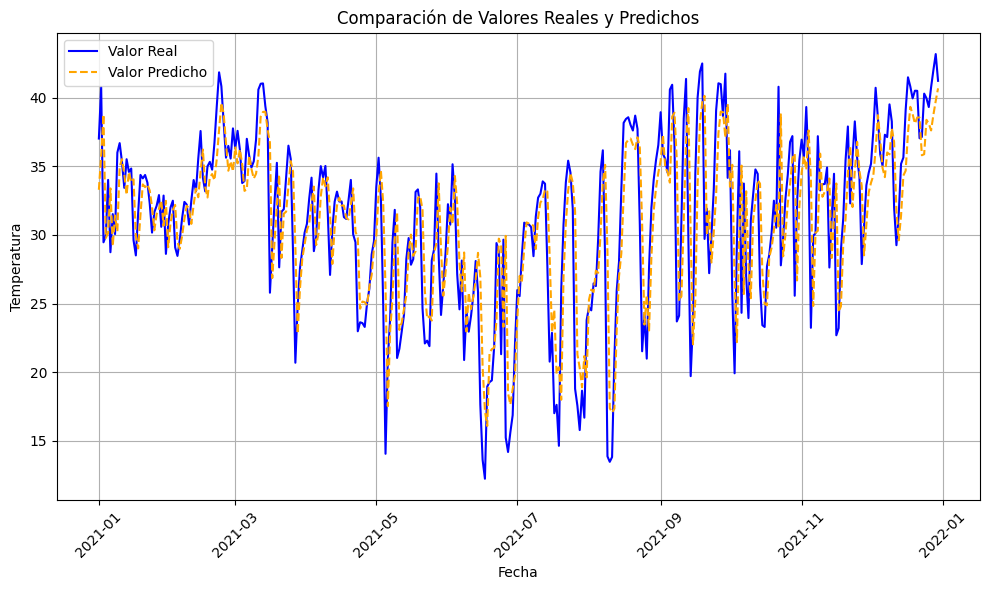

In [94]:
# Crear un DataFrame con los valores reales y predichos
result_df = pd.DataFrame({
    'Fecha': daily_max_temperatures.index[val_indices],
    'Valor Real': y_val,
    'Valor Predicho': y_pred
})

# Generar el gráfico temporal
plt.figure(figsize=(10, 6))
plt.plot(result_df['Fecha'], result_df['Valor Real'], label='Valor Real', color='blue')
plt.plot(result_df['Fecha'], result_df['Valor Predicho'], label='Valor Predicho', linestyle='--', color='orange')
plt.title('Comparación de Valores Reales y Predichos')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


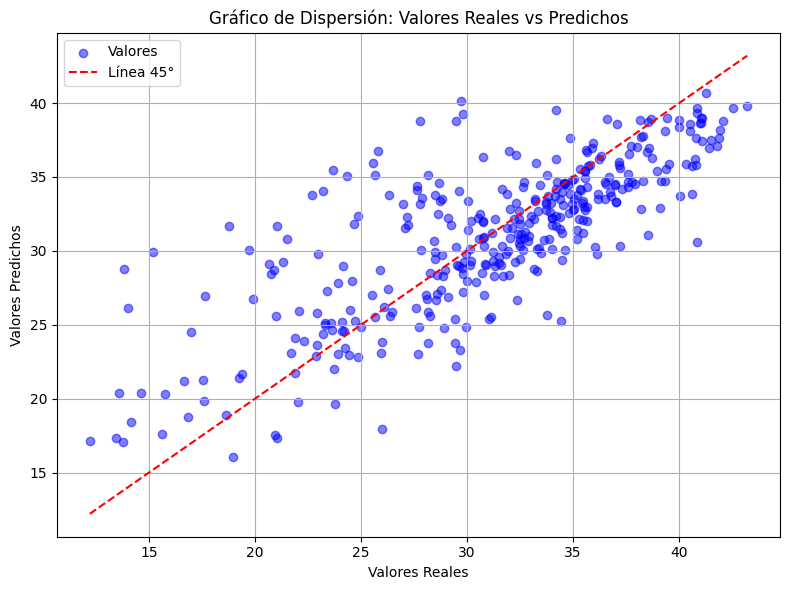

In [95]:

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(result_df['Valor Real'], result_df['Valor Predicho'], color='blue', alpha=0.5, label='Valores')

# Añadir una línea de 45 grados
min_val = min(result_df['Valor Real'].min(), result_df['Valor Predicho'].min())
max_val = max(result_df['Valor Real'].max(), result_df['Valor Predicho'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Línea 45°')

# Etiquetas y título
plt.title('Gráfico de Dispersión: Valores Reales vs Predichos')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Añadiendo parametros extras

In [97]:


# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()
daily_max_humidity = data['Humedad'].resample('D').max()

# Definir características (features): temperatura y humedad
X = pd.DataFrame({
    'Temperatura': daily_max_temperatures.values[:-1],
    'Humedad': daily_max_humidity.values[:-1]
})

# Variable objetivo (target)
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (daily_max_temperatures.index.year <= 2020)[:-1]
val_indices = (daily_max_temperatures.index.year == 2021)[:-1]

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error en validación: {mse}")
r2_tyh=best_model.score(X_val, y_val)
print(f"R^2: {r2_tyh}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}
Mean Squared Error en validación: 16.76318180710129
R^2: 0.5971168299412601


In [80]:
r2_solotemp

0.5974254087131923

In [81]:
r2_tyh

0.5971168299412601

In [83]:
r2_solotemp-r2_tyh #Es mejor el metodo calculado con solo la temperatura

0.0003085787719321331